In [233]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = (9, 7)


## Loading and ploting the image

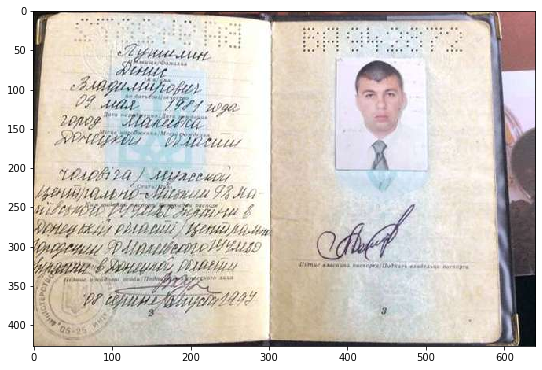

In [390]:
IMG_PATH = 'images/4.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_orig = img.copy()
plt.imshow(img)

## Edge detection

In [391]:
def detect_edges(img, min_val=200, max_val=250):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply filter, threshold and blur
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    img = cv2.medianBlur(img, 11)
    
    # Add border
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Apply Canny edge detector
    img = cv2.Canny(img, min_val, max_val)
    
    # Apply morph transformation (img => erosion => dilation)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5, 11)))
    return img

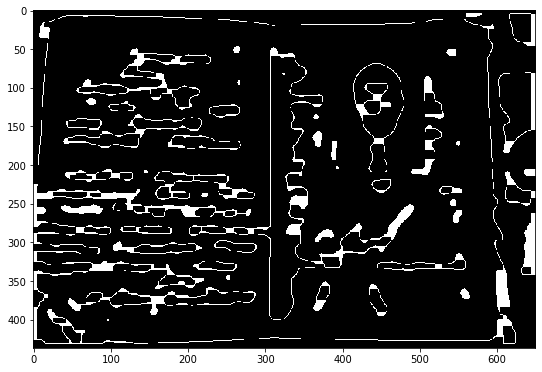

In [392]:
edges_img = detect_edges(img)
plt.imshow(edges_img, cmap='gray')

## Finding contours

In [393]:
def find_contours(edges_img):
    # Get contours
    contours, hierarchy = cv2.findContours(edges_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the biggest rectangle
    height, width = edges_img.shape
    MIN_CONTOUR_AREA = width * height * 0.5

    max_area = MIN_CONTOUR_AREA
    max_contour = np.array([[0, 0],
                           [0, height-5],
                           [width-5, height-5],
                           [width-5, 0]])

    for contour in contours:
        perimeter = cv2.arcLength(contour, closed=True)
        approx = cv2.approxPolyDP(contour, 0.03 * perimeter, closed=True)

        if(len(approx) == 4 and max_area < cv2.contourArea(approx)):
            max_area = cv2.contourArea(approx)
            max_contour = approx[:, 0]
    
    return contour_offset(max_contour, (-5, -5))


def offset_contour(contour, offset):
    contour += offset
    contour[contour < 0] = 0
    return contour

Contours:
 [[  5  14]
 [  0 421]
 [618 425]
 [589  13]]


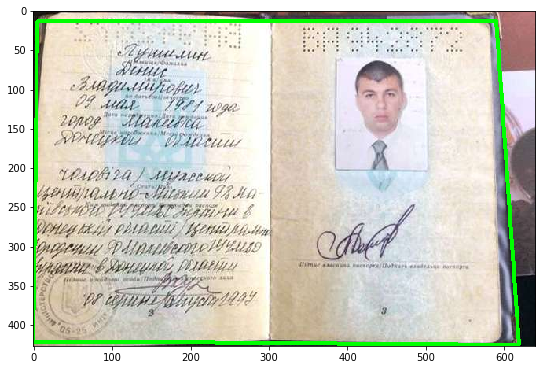

In [394]:
contours = find_contours(edges_img)
print('Contours:\n', contours)
plt.imshow(cv2.drawContours(img_orig, [contours], -1, (0, 255, 0), 3))

## Transform perspective

In [395]:
def transform_perspective(img_orig, contours, width=800, height=800):
    # Create target points
    target_points = np.array([[0, 0],
                             [0, height],
                             [width, height],
                             [width, 0]], dtype=np.float32)
    
    contours = contours.astype(np.float32)
    
    # Calculate matrix to transform
    M = cv2.getPerspectiveTransform(contours, target_points)
    
    transformed_img = cv2.warpPerspective(img_orig, M, (width, height))
    
    

TypeError: Image data of dtype object cannot be converted to float

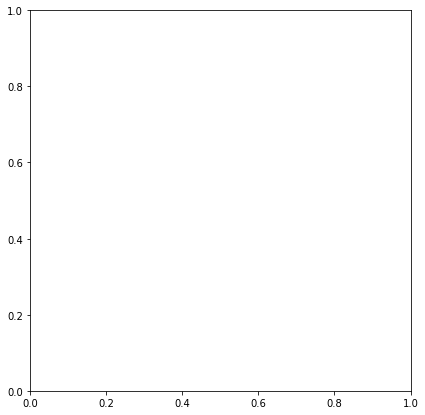

In [396]:
final_img = transform_perspective(img_orig, contours)
plt.imshow(final_img)